#### Simulation

##### Import

In [9]:
import numpy as np
import itertools
import requests
import polyline
import json
import os

import random as rd
import pandas as pd

from shapely.geometry import Point

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import warnings 

warnings.filterwarnings('ignore')

##### 좌표 거리 생성 함수

In [10]:
# 직선 거리 게산 함수
def calculate_straight_distance(lat1, lon1, lat2, lon2):
    # 지구 반경 (킬로미터 단위)
    km_constant = 3959* 1.609344
    # 위도와 경도를 라디안으로 변환
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    # 위도 및 경도 차이 계산
    dlat = lat2 - lat1 
    dlon = lon2 - lon1
    # Haversine 공식 계산
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    # 거리 계산 (킬로미터 단위)
    km = km_constant * c
    
    return km

##### trips 데이터 생성 함수

In [11]:
#### osrm 페키지로 경로 추출
# 입력으로 받은 출발지와 목적지 좌표를 이용하여 경로 정보를 가져오는 함수
def get_res(point):

   status = 'defined'

   # 요청을 재시도할 수 있도록 세션 객체 생성 및 설정
   session = requests.Session()
   retry = Retry(connect=3, backoff_factor=0.5)
   adapter = HTTPAdapter(max_retries=retry)
   session.mount('http://', adapter)
   session.mount('https://', adapter)

   #### url 생성 코드
   # 전체 경로 정보를 요청
   overview = '?overview=full'
   # lon, lat, lon, lat 형식의 출발지 목적지 좌표
   loc = f"{point[0]},{point[1]};{point[2]},{point[3]}"
   # 보행경로 url
   url = 'http://router.project-osrm.org/route/v1/foot/'
   # 경로 정보 요청
   r = session.get(url + loc + overview) 
   
   # 만약 경로가 안뜰 때 대체 결과 생성
   if r.status_code!= 200:
      
      status = 'undefined'
      
       # 직선 거리 계산
      distance = calculate_straight_distance(point[1], point[0], point[3], point[2]) * 1000
      
      # 경로 정보 생성 (출발지와 목적지 좌표만 포함)
      route = [[point[0], point[1]], [point[2], point[3]]]

      # 소요 시간 및 타임스탬프 계산 (가정: 보행 속도 10km/h)
      speed_km = 10#km
      speed = (speed_km * 1000/60)      
      duration = distance/speed
      
      timestamp = [0, duration]

      result = {'route': route, 'timestamp': timestamp, 'duration': duration, 'distance' : distance}
   
      return result, status
   
   # 경로 정보를 성공적으로 가져온 경우, JSON 응답을 반환
   res = r.json()   
   return res, status

In [12]:
# 경로를 가는데 걸리는 시간과 거리 추출 함수
def extract_duration_distance(res):
   # get_res함수에서 추출된 데이터에서 시간과 거리 뽑기
   
   duration = res['routes'][0]['duration']/(60)  # 분 단위로 변환
   distance = res['routes'][0]['distance']
   
   return duration, distance

# 경로 추출 함수
def extract_route(res):
   
    # get_res함수에서 추출된 데이터에서 경로 뽑기
    # 경로가 인코딩 되어 있기 때문에 아래 함수를 써서 디코딩해주어야지 위경도로 이루어진 경로가 나옴
    route = polyline.decode(res['routes'][0]['geometry'])
    
    # 사용할 형식에 맞춰 위경도 좌표의 위치를 바꿔주는 것
    route = list(map(lambda data: [data[1],data[0]] ,route))
    
    return route

In [13]:
# 총 걸리는 시간을 경로의 거리 기준으로 쪼개주는 함수
def extract_timestamp(route, duration):
    
    # 리스트를 numpy이 배열로 변경
    rt = np.array(route)
    # 리스트를 수평 기준으로 합치기
    rt = np.hstack([rt[:-1,:], rt[1:,:]])
    # 각각 직선거리 추출(리스트 형태)
    per = calculate_straight_distance(rt[:,1], rt[:,0], rt[:,3], rt[:,2])
    # 각각의 직선거리를 전체 직선거리의 합으로 나누기
    per = per / np.sum(per)

    # 계산된 비율을 기반으로 각 지점 도착 예상 시간 계산
    timestamp = per * duration
    timestamp = np.hstack([np.array([0]),timestamp])
    timestamp = list(itertools.accumulate(timestamp)) 
    
    return timestamp

In [14]:
# 모든 함수를 한번에 실행하는 코드(trips 데이터의 형태로 저장)
def osrm_routing_machine(O, D):

   # osrm 데이터 생성
   osrm_base, status = get_res([O.x, O.y, D.x, D.y])
   
   # osrm 데이터가 생성 됬으면 진행
   if status == 'defined':
      # 거리 및 걸리는 시간 추출
      duration, distance = extract_duration_distance(osrm_base)
      # 경로 추출
      route = extract_route(osrm_base)
      # timestamp 생성
      timestamp = extract_timestamp(route, duration)
      # 결과 저장
      result = {'route': route, 'timestamp': timestamp, 'duration': duration, 'distance' : distance}
      
      return result
   else: 
      return osrm_base
# OD_data 한쌍일 때 osrm_routing_machine작동함수
def osrm_routing_machine_multiprocess(OD):
   O, D = OD
   result = osrm_routing_machine(O, D)
   return result
# OD_data 데이터가 리스트쌍 일때의 osrm_routing_machine 작동함수
def osrm_routing_machine_multiprocess_all(OD_data):
    results = list(map(osrm_routing_machine_multiprocess, OD_data))
    return results

##### od 데이터 생성

In [15]:
def get_OD_data(point, num=10):
    """
    Generate random origin-destination pairs from given points
    
    Args:
        point (dict): Dictionary containing points data
        num (int): Number of OD pairs to generate
    
    Returns:
        list: List of OD pairs as [Origin Point, Destination Point]
    """
    OD_data = []
    
    # Convert dictionary keys to list for random sampling
    point_keys = list(point.keys())
    
    # Generate num random pairs of coordinates
    for _ in range(num):
        # Generate random pair using the point keys
        neighborhood1, neighborhood2 = rd.sample(point_keys, 2)
        # Get start and end points from the dictionary
        start_point = point[neighborhood1]
        end_point = point[neighborhood2]
        
        # Convert to shapely Point objects
        O = Point(start_point)
        D = Point(end_point)
        # Add origin-destination pair to list
        OD_data.append([O, D])
    
    return OD_data

In [16]:
# 데이터 좌표
point = {
    "가천대_반도체대학" : [127.127384 , 37.450910],
    "가천대_일반대학원" : [127.130112 , 37.452589],
    "가천대_교육대학원" : [127.131698 , 37.452066],
    "가천대_학생회관" : [127.134042 , 37.453336],
    "가천대_ai_공학관" : [127.133374 , 37.455009],
}


In [17]:
# O는 출발지 D는 도착지로 생각하면 편함
OD_data = get_OD_data(point, 10)
OD_data

[[<POINT (127 37.5)>, <POINT (127 37.5)>],
 [<POINT (127 37.5)>, <POINT (127 37.5)>],
 [<POINT (127 37.5)>, <POINT (127 37.5)>],
 [<POINT (127 37.5)>, <POINT (127 37.5)>],
 [<POINT (127 37.5)>, <POINT (127 37.5)>],
 [<POINT (127 37.5)>, <POINT (127 37.5)>],
 [<POINT (127 37.5)>, <POINT (127 37.5)>],
 [<POINT (127 37.5)>, <POINT (127 37.5)>],
 [<POINT (127 37.5)>, <POINT (127 37.5)>],
 [<POINT (127 37.5)>, <POINT (127 37.5)>]]

##### trips 데이터 생성

In [18]:
# OD, DO 포인트에 대해서 각각의 trips데이터를 생성
OD_results = osrm_routing_machine_multiprocess_all(OD_data)

In [19]:
OD_results

[{'route': [[127.13181, 37.45222],
   [127.13176, 37.45229],
   [127.13173, 37.45232],
   [127.13161, 37.45229],
   [127.13152, 37.45226],
   [127.13144, 37.45222],
   [127.13137, 37.45216],
   [127.13131, 37.45206],
   [127.13125, 37.45197],
   [127.13121, 37.45196],
   [127.13117, 37.45196],
   [127.13113, 37.45196],
   [127.1311, 37.45198],
   [127.13106, 37.45202],
   [127.13067, 37.45254],
   [127.13063, 37.45258],
   [127.1306, 37.45259],
   [127.13057, 37.4526],
   [127.13049, 37.45259],
   [127.13035, 37.45255],
   [127.13019, 37.45249],
   [127.13017, 37.45249]],
  'timestamp': [0.0,
   0.03921645212836079,
   0.057883426775250116,
   0.10655646951599018,
   0.14432040901538673,
   0.180897966390423,
   0.22075274279634124,
   0.27473252692677436,
   0.3243568282250198,
   0.34058124289081454,
   0.356056442785123,
   0.37153164267943145,
   0.3866877599304728,
   0.4115770986986621,
   0.7065095387321293,
   0.7313988054637783,
   0.7439867409441088,
   0.7565746749913446,
  

##### timestamp 변경

In [20]:
# 원하는 범위에서 랜덤함 숫자를 원하는 만큼 뽑아내는 함수
def sample_interval(start, end, count, num_samples):
    # 시작과 끝을 count만 큼 나눔(최종 : 나눈 만큼의 숫자가 생성됨)
    interval_size = (end - start) / count
    samples = []
    # 랜덤 숫자 생성
    for i in range(count):
        interval_start = start + interval_size * i
        interval_end = interval_start + interval_size
        samples.extend(rd.sample(range(int(interval_start), int(interval_end)), num_samples))
    return samples

### ex.
# 시작 시간과 출발 시간 사이의 랜덤 숫자 생성
# 초 기준
sample_interval(0, 50, 10, 1)

[4, 7, 14, 15, 23, 29, 34, 35, 43, 46]

In [21]:
# 시각화 할때 겹치지 않기 하기 위해서 임의의 시간을 더해주는 함수
# 시간 범위를 정하고 싶으면 아래의  sample_interval의 앞의 두개의 인풋값 바꿔주기!
def timestamp_change(OD_results) :
    random_numbers = sample_interval(0, 50, len(OD_results), 1)
    for i in range(0, len(OD_results)) :
        # (i+1)*3을 더해주는 이유는 출발 시간이 겹치지 않기 하기 위해서
        OD_results[i]['timestamp'] = list(np.array(OD_results[i]['timestamp']) + random_numbers[i])
        
    return OD_results

In [22]:
# timestamp 변경
OD_results = timestamp_change(OD_results)

In [23]:
# 시작 시간이 잘 변경 되었나 확인
OD_results[0]['timestamp'][0], OD_results[-1]['timestamp'][0]

(3.0, 45.0)

##### 데이터 저장

In [77]:
# 데이터 저장
path = '../simulation/src/data/'

with open(os.path.join(path + 'trips.json'), 'w', encoding='utf-8') as file:
    json.dump(OD_results, file)

#### 실습

##### 100개의 od를 뽑아서 시뮬레이션을 만들고 깃허브에 올려서 시뮬레이션 링크를 사이버캠퍼스에 제출

In [ ]:
# 데이터 좌표
point = {
    "중앙시장사거리" : [127.131770, 37.440888],
    "숯골사거리" : [127.142398 , 37.444055],
    "동부센트레빌2단지아파트" : [127.129460 , 37.447540],
    "수진역" : [127.140851 , 37.437443],
    "개별용달" : [127.139292 , 37.446605],
    "버거킹" : [127.150505 , 37.442235],
}

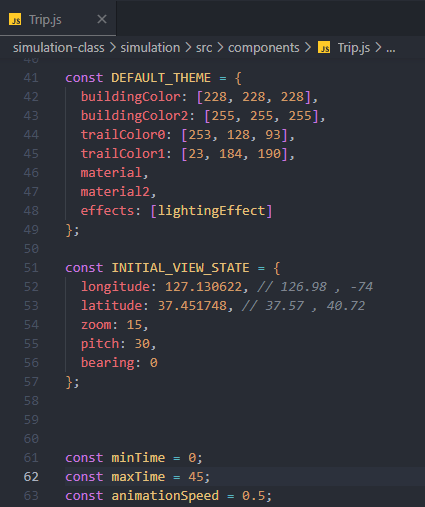

과제 할때 simulation-class/smulation/src/components/Trips.json에 들가면 maxTime 최소 350이상으로 설정하기

longitude = 127.135840
latitude = 37.442836
로 설정하기

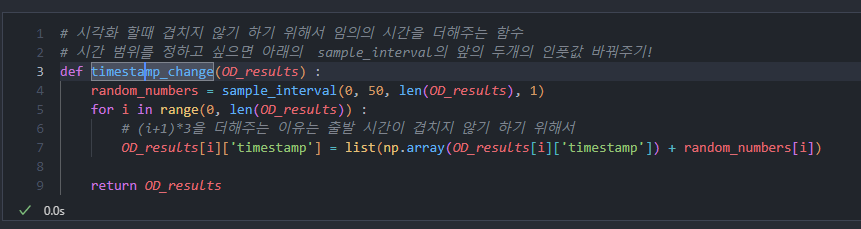

- 과제 할때 위의 함수에서 아래와 같이 수정(안하면 시뮬레이션이 잘림)
- random_numbers = sample_interval(0, 50, len(OD_results), 1) ->  random_numbers = sample_interval(0, 300, len(OD_results), 1)